## Lets do some dataset exploration
- we will start by importing a section of our dataset to get an idea about what is in it


In [1]:
import pandas as pd

#constant to keep trakc of where the datafiles are stored
DATA_FILES_PATH = 'projectDataFiles/'
LABEL = 'fare_amount'

INTRO_DF = pd.read_csv(f'{DATA_FILES_PATH}train.csv', nrows=2000000)

# describe the dataset
INTRO_DF.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


### Finding possible outliers we can remove
- above we can see that there are some entries with zero passengers!
- there is also some crazy latitude and longitudes in the set

### Now let's plot our data to learn more

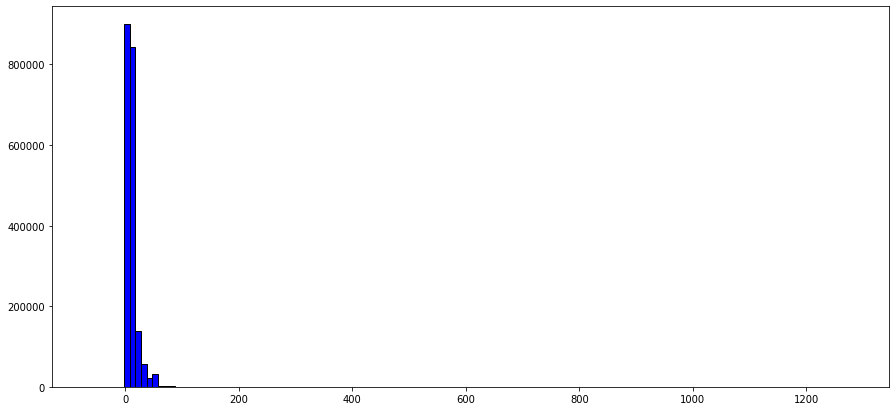

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure(figsize=(15, 7))
plt.hist(INTRO_DF['fare_amount'], color = 'blue', edgecolor = 'black', bins = np.arange(min(INTRO_DF['fare_amount']), max(INTRO_DF['fare_amount']) + 10, 10))
plt.show()

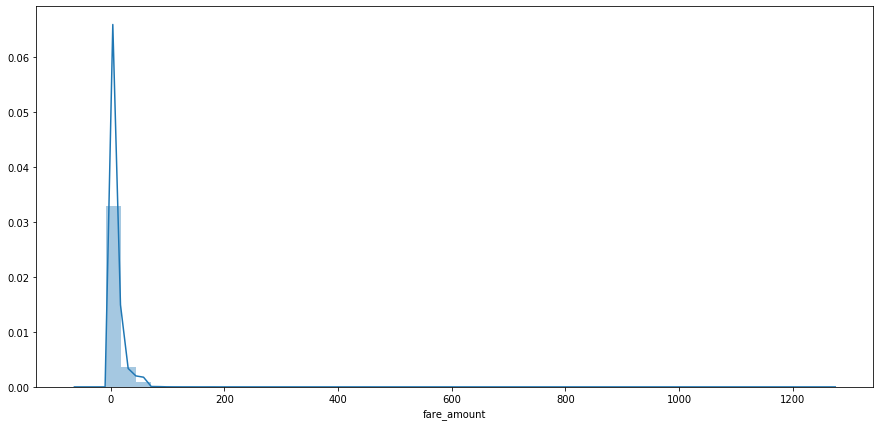

In [3]:
import seaborn as sbn

plt.figure(figsize=(15, 7))
sbn.distplot(INTRO_DF['fare_amount'])
plt.show()

In [4]:
print(f'Number of Negative fare amounts: {len(INTRO_DF[INTRO_DF[LABEL] < 0])}')
print(f'Number of very high fare amounts: {len(INTRO_DF[INTRO_DF[LABEL] >= 100])}')

# remove the negative and zero fare amounts
INTRO_DF[INTRO_DF[LABEL] > 0].describe()

Number of Negative fare amounts: 77
Number of very high fare amounts: 857


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999867e+06,1.999867e+06,1.999867e+06,1.999853e+06,1.999853e+06,1.999867e+06
mean,1.134884e+01,-7.252341e+01,3.992974e+01,-7.252452e+01,3.992839e+01,1.684119e+00
std,9.852016e+00,1.286765e+01,7.983215e+00,1.277354e+01,1.032346e+01,1.314988e+00
min,1.000000e-02,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075313e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


Taxis with zero passengers: 7123


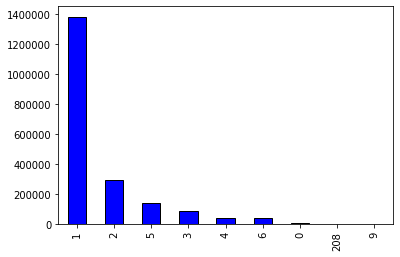

In [5]:
print(f"Taxis with zero passengers: {len(INTRO_DF[INTRO_DF['passenger_count'] == 0])}")
INTRO_DF['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k')
plt.show()

In [6]:
import geopandas as gpd

# NYC Boundaries
NYC_BOUNDARY = (-74.5, -72.8, 40.5, 41.8) # in format WEST, EAST, NORTH, SOUTH

# plot out the latitudes and longitudes on this map

## Define a function to get the real distance between to lat/long points
- Manhattan distance should be useful, but I think we can do better with real distance
- Here we compare a manual calculation to the geopy library

In [7]:
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
import reverse_geocoder as rg
import numpy as np

def geo_manhattan_distance(lat1, lat2, long1, long2):
    """
    returns the manhattan distance between two geo points
    """
    return abs(lat2 - lat1) + abs(long2 - long1)

def geopy_dist(coord1, coord2):
    try:
        return geopy.distance.distance(coord1, coord2).kilometers
    except:
        return -1

def haversine(lat1, lon1, lat2, lon2, m_const=3958.8):
    lat1, lon1, lat2, lon2 = map(abs, [lat1, lon1, lat2, lon2])
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    mi = m_const * c
    return mi            

## Here we define some filter functions that can help us remove outliers from our dataset
- within boundary limits the dataset to only geo points in the boundary zone
- not_at_airport is a function to filter out those getting picked up or dropped off at an airport
- reasonable_fare is a way to limit outlier fares (see plots below on why values were chosen)

In [8]:
# filter functions to reduce the dataset
def within_boundary(dataframe, boundary):
    return (dataframe['pickup_longitude'] >= boundary[0]) & (dataframe['pickup_longitude'] <= boundary[1]) & \
            (dataframe['pickup_latitude'] >= boundary[2]) & (dataframe['pickup_latitude'] <= boundary[3]) & \
            (dataframe['dropoff_longitude'] >= boundary[0]) & (dataframe['dropoff_longitude'] <= boundary[1]) & \
            (dataframe['dropoff_latitude'] >= boundary[2]) & (dataframe['dropoff_latitude'] <= boundary[3])

def not_at_airport(dataframe):
    return ~((dataframe['pickup_to_jfk'] < 1) | (dataframe['dropoff_to_jfk'] < 1)) & \
            ~((dataframe['pickup_to_laguardia'] < 1) | (dataframe['dropoff_to_laguardia'] < 1))


def has_passengers(dataframe):
    return (dataframe['passenger_count'] != 0)
    
def reasonable_fare(dataframe):
    return (dataframe['fare_amount'].between(left=0, right=100))

## Define a process dataframe function
- this function will perform our feature engineering and feature removals

In [9]:
def process_df(dataframe, train_data=True):
    pd.set_option('use_inf_as_na', True)
    dataframe['pickup_datetime'] = dataframe['pickup_datetime'].str.slice(0, 16)
    dataframe['pickup_datetime'] = pd.to_datetime(dataframe['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    # the distance between the pickup and dropoff points
    dataframe['real_dist'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], dataframe['dropoff_latitude'], dataframe['dropoff_longitude'])

    # add the deconstructed date
    dataframe['hour'] = dataframe['pickup_datetime'].dt.hour
    dataframe['day'] = dataframe['pickup_datetime'].dt.day
    dataframe['month'] = dataframe['pickup_datetime'].dt.month
    dataframe['year'] = dataframe['pickup_datetime'].dt.year
    
    add_year = pd.get_dummies(dataframe['year'], prefix='year')
    
    dataframe = pd.concat([dataframe, add_year], axis=1)
    
    # converting cyclical variables to sin / cos
    dataframe['hour_sin'] = np.sin(dataframe['hour'] * ( 2 * np.pi / 24))
    dataframe['hour_cos'] = np.cos(dataframe['hour'] * ( 2 * np.pi / 24))
    dataframe['day_sin'] = np.sin(dataframe['day'] * ( 2 * np.pi / 7))
    dataframe['day_cos'] = np.cos(dataframe['day'] * ( 2 * np.pi / 7))
    dataframe['month_sin'] = np.sin((dataframe['month'] - 1) * (2 * np.pi / 12))
    dataframe['month_cos'] = np.cos((dataframe['month'] - 1) * (2 * np.pi / 12))

    # add the distances to the airports
    dataframe['pickup_to_jfk'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], JFK_COORD[0], JFK_COORD[1])
    dataframe['dropoff_to_jfk'] = haversine(dataframe['dropoff_latitude'], dataframe['dropoff_longitude'], JFK_COORD[0], JFK_COORD[1])
    dataframe['pickup_to_laguardia'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], LAGUARDIA_COORD[0], LAGUARDIA_COORD[1])
    dataframe['dropoff_to_laguardia'] = haversine(dataframe['dropoff_latitude'], dataframe['dropoff_longitude'], LAGUARDIA_COORD[0], LAGUARDIA_COORD[1])
    
    # distance from center of new york
    dataframe['dropoff_from_center'] = haversine(dataframe['dropoff_latitude'], dataframe['dropoff_longitude'], NYC_COORD[0], NYC_COORD[1])
    dataframe['pickup_from_center'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], NYC_COORD[0], NYC_COORD[1])
        
    # get abs lat / lon distances
    dataframe['dlat'] = abs(dataframe['pickup_latitude'] - dataframe['dropoff_latitude'])
    dataframe['dlon'] = abs(dataframe['pickup_longitude'] - dataframe['dropoff_longitude'])
    dataframe['m_dist'] = geo_manhattan_distance(dataframe['pickup_latitude'], dataframe['pickup_longitude'], dataframe['dropoff_latitude'], dataframe['dropoff_longitude'])
    
    # limit to the boundary
    dataframe = dataframe[within_boundary(dataframe, NYC_BOUNDARY) & has_passengers(dataframe) & reasonable_fare(dataframe)].copy()

    # drop uneccessary columns
    dataframe.drop([
        'key',
        'pickup_datetime', 
        'pickup_longitude', 
        'pickup_latitude', 
        'dropoff_latitude', 
        'dropoff_longitude'
    ], axis=1, inplace=True)
    
    dataframe.dropna(axis=1, how='any', inplace=True)
    return dataframe

## Import our dataset
- our dataset consists of several files:
    - train.csv: our training data
    - test.csv: our testing data
    - sample_submissions.csv: A sample submission file in the correct format (columns key and fare_amount). This dummy file 'predicts' fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.

In [10]:
import pandas as pd
import os
import sys
import random
from sklearn.model_selection import train_test_split

# set the constants for the dataset
TOTAL_ROWS = 55423855

NYC_COORD = (40.7580, 73.9855)
JFK_COORD = (40.6413, 73.7781)
LAGUARDIA_COORD = (40.7769, 73.8740)

# training data types
TRAINING_TYPES = {
    'fare_amount': 'float32',
    'pickup_datetime': 'str',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

LABEL = 'fare_amount'

def import_training_dataset_limit(file_path, row_limit=100000):
    """
    function to import the dataset into a pandas dataframe.

    Takes a row limit to limit the number of rows read.
    """
    if row_limit:
        return process_df(pd.read_csv(file_path, nrows=row_limit))
    else:
        return process_df(pd.read_csv(file_path))


def get_df_list(file_path, chunksize=1000000):
    df_list = []
    counter = 0
    for df_chunk in pd.read_csv(file_path, chunksize=chunksize, dtype=TRAINING_TYPES):
        counter += 1
        print(counter)
        df_chunk = process_df(df_chunk)
        df_list.append(df_chunk)
    return df_list
        


def read_feathered_data(file_path):
    return pd.read_feather(file_path)

def feather_dataset(dataframe, file_out):
    dataframe.to_feather(file_out)

# import the dataset as a list of chunks, from here we can do our processing at a chunk level
print('Importing Datasets...')
# DATA_LIST = get_df_list(f'{DATA_FILES_PATH}train.csv')

# train_split = int(len(DATA_LIST) * 0.8)

# random.shuffle(DATA_LIST)

# TRAINING_LIST = DATA_LIST[:train_split]

# TEST = pd.concat(DATA_LIST[train_split:])

# TRAINING_LIST[0].head()

# import the dataset for testing 
DF = import_training_dataset_limit(f'{DATA_FILES_PATH}train.csv')

# print(list(DF.columns))

DF.head()

TRAIN, TEST = train_test_split(DF, test_size=0.2, random_state=5)
TRAIN.head()

FEATURES = [
    #'hour',
    'hour_cos',
    'hour_sin',
    'month_cos',
    'month_sin',
    'day_cos',
    'day_sin',
#     'year_2009',
#     'year_2010',
#     'year_2011',
#     'year_2012', 
#     'year_2013',
#     'year_2014',
#     'year_2015',
    'real_dist',
    'dlat',
    'dlon',
    'm_dist',
#     'airport_True', 
#     'airport_False', 
    'pickup_from_center',
    'dropoff_from_center',
    'pickup_to_jfk',
    'dropoff_to_jfk',
    'pickup_to_laguardia',
    'dropoff_to_laguardia'
]

Importing Datasets...


In [11]:
TEST.head()

,fare_amount,passenger_count,real_dist,hour,day,month,year,year_2009,year_2010,year_2011,...,month_cos,pickup_to_jfk,dropoff_to_jfk,pickup_to_laguardia,dropoff_to_laguardia,dropoff_from_center,pickup_from_center,dlat,dlon,m_dist
48252,4.9,5,1.380257,17,30,5,2012,0,0,0,...,-5.000000e-01,14.706600,14.084860,5.396472,5.669037,1.115770,2.490678,0.019179,0.007380,229.524279
14052,24.0,2,4.284720,20,12,12,2012,0,0,0,...,8.660254e-01,12.945070,11.458630,6.848437,2.614083,3.374946,1.654580,0.031630,0.070410,229.415160
61769,7.5,1,1.284024,15,1,1,2015,0,0,0,...,1.000000e+00,12.874651,12.850303,4.544124,5.555247,0.679211,1.475081,0.014580,0.015213,229.453812
55804,3.7,1,0.455394,8,8,3,2010,0,1,0,...,5.000000e-01,13.075239,13.436281,5.580393,5.594760,0.437996,0.476440,0.006375,0.002209,229.473846
98895,7.7,1,1.358834,5,27,4,2009,1,0,0,...,6.123234e-17,12.837103,13.344490,7.217733,8.537741,3.407270,2.186542,0.013509,0.018858,229.450469


## Perform a SGD partial fit
- SGD stands for stochastic gradient descent
- Here we are feeding our chunks into the partial fit

In [12]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

def sgd_train(chunk_list, loss="squared_loss"):
    my_sgd_regressor = SGDRegressor(loss=loss, random_state=5)
    my_sgd_regressor.n_iter = np.ceil(10**6 / len(TEST[LABEL]))
    scaler = StandardScaler()
    for chunk in chunk_list:
        X_train = chunk[FEATURES]
        scaler.fit(X_train)
        my_sgd_regressor.partial_fit(scaler.transform(X_train), chunk[LABEL])
    X_test = TEST[FEATURES]
    y_predict = my_sgd_regressor.predict(scaler.transform(X_test))
    return y_predict

print('Getting SGD predictions...')
# Y_PREDICT_SGD = sgd_train(TRAINING_LIST)
Y_PREDICT_SGD = sgd_train([TRAIN])

Getting SGD predictions...


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from functools import reduce

feature_importances = []

def get_best_rf_params(training_data):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf = RandomForestRegressor()
    rf_r = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=5, n_jobs = -1)
    rf_r.fit(training_data[FEATURES], training_data[LABEL])
    return rf_r.best_params_

    
def rf_train_warm_start(chunk_list, n_estimators = 1):
    global feature_importances
    
    rf = RandomForestRegressor(
        n_estimators = n_estimators,
        bootstrap = True,
        random_state=5,
        verbose=2,
        n_jobs=-1
    )
    
    scaler = StandardScaler()
    for index, chunk in enumerate(chunk_list):
        X_train = chunk[FEATURES]
        scaler.fit(X_train)
        rf.fit(scaler.transform(X_train), chunk[LABEL])
        if index != len(chunk_list) - 1:
            rf.n_estimators += n_estimators
    X_test = TEST[FEATURES]
    y_predict = rf.predict(scaler.transform(X_test))
    
    # set global feature_importances
    feature_importances = sorted(
        [(feature, round(importance, 2)) for feature, importance in zip(FEATURES, rf.feature_importances_)], 
        key = lambda x: x[1], 
        reverse = True
    )
    
    return y_predict

#print(get_best_rf_params(TRAIN))
print('Getting RF Predictions...')
# Y_PREDICT_RF = rf_train_warm_start(TRAINING_LIST)
Y_PREDICT_RF = rf_train_warm_start([TRAIN], n_estimators=20)

# TODO: Add preview of predictions

Getting RF Predictions...
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20building tree 8 of 20




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


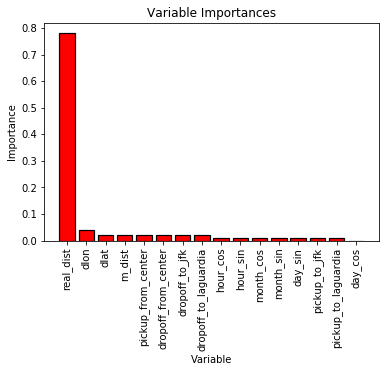

In [14]:
def plot_feature_importances_bar(feature_importances):
    %matplotlib inline
    x_values = list(range(len(feature_importances)))
    plt.bar(x_values, [i[1] for i in feature_importances], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
    plt.xticks(x_values, [i[0] for i in feature_importances], rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title('Variable Importances')

plot_feature_importances_bar(feature_importances)

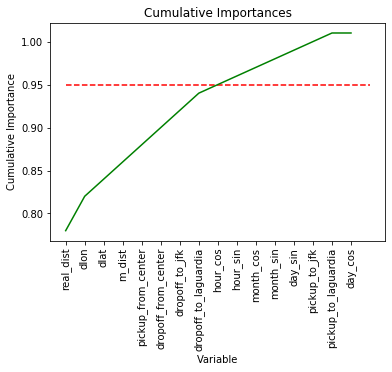

In [15]:
def plot_feature_importances_cumulative(feature_importances):
    %matplotlib inline
    x_values = list(range(len(feature_importances)))
    # List of features sorted from most to least important
    sorted_importances = [importance[1] for importance in feature_importances]
    sorted_features = [importance[0] for importance in feature_importances]
    # Cumulative importances
    cumulative_importances = np.cumsum(sorted_importances)
    # Make a line graph
    plt.plot(x_values, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
    # Format x ticks and labels
    plt.xticks(x_values, sorted_features, rotation = 'vertical')
    # Axis labels and title
    plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

plot_feature_importances_cumulative(feature_importances)

In [16]:
import lightgbm as lgb

def lgb_train(training_data):
    lgb_regressor = lgb.LGBMRegressor(objective='regression', random_state=5)
    lgb_regressor.fit(training_data[FEATURES], training_data[LABEL])
    return lgb_regressor.predict(TEST[FEATURES])

# Y_PREDICT_LGB = lgb_train(pd.concat(TRAINING_LIST))
Y_PREDICT_LGB = lgb_train(TRAIN)

# preview predictions

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [17]:
from sklearn import metrics
import numpy as np

def calc_rmse(y_test, y_prediction):
    # Calculating "Mean Square Error" (MSE):
    mse = metrics.mean_squared_error(y_test, y_prediction)

    # Using numpy sqrt function to take the square root and calculate "Root Mean Square Error" (RMSE)
    return np.sqrt(mse)

print(f'SGB RMSE: {calc_rmse(TEST[LABEL], Y_PREDICT_SGD)}')
print(f'RF RMSE: {calc_rmse(TEST[LABEL], Y_PREDICT_RF)}')
print(f'LGB RMSE: {calc_rmse(TEST[LABEL], Y_PREDICT_LGB)}')

# TODO: Add variance calculations and predict TEST csv values

SGB RMSE: 4.834466926687685
RF RMSE: 3.982715144080141
LGB RMSE: 3.835575465806938
